<a href="https://colab.research.google.com/github/Lenches/semantics/blob/main/Semantic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q sentence-transformers

In [ ]:
import os
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

model = SentenceTransformer('cointegrated/rubert-tiny')

def read_words_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read()
        words = [w.strip().lower() for w in content.split(",") if w.strip()]
    return words

def compute_cosine_similarities(words):
    embeddings = model.encode(words)
    return [cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
            for i in range(len(embeddings) - 1)]

extract_dirs = [
    "/content/data/HPR_animals",
    "/content/data/Healthy_animals"
]

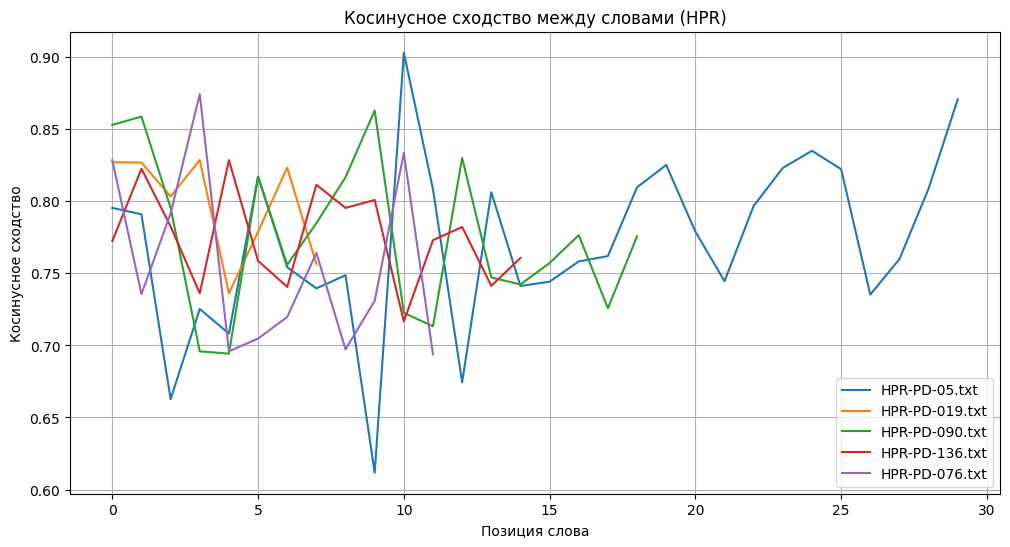

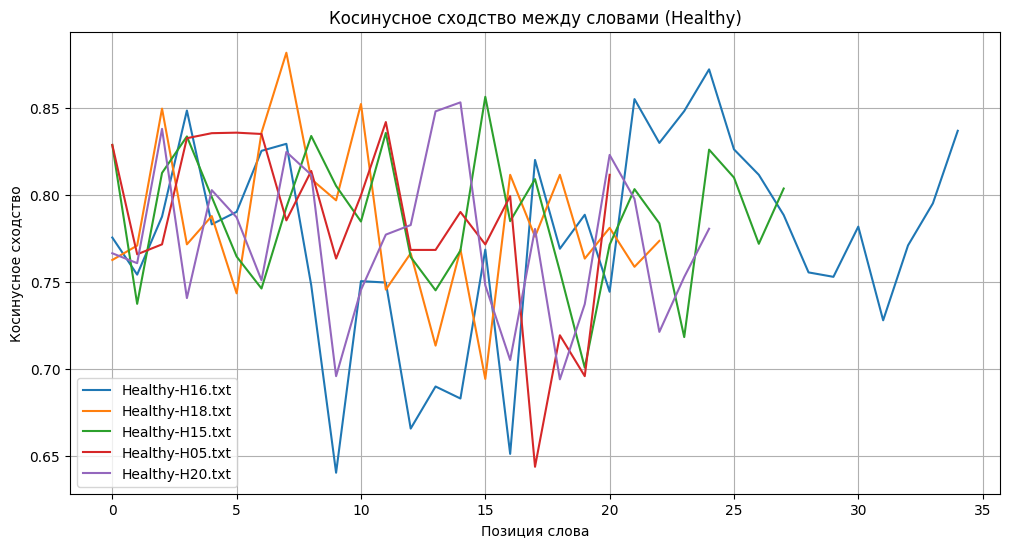

In [ ]:
cosine_results = {"HPR": {}, "Healthy": {}}

for filename in os.listdir(extract_dirs[0]):
    path = os.path.join(extract_dirs[0], filename)
    words = read_words_from_file(path)
    if len(words) >= 2:
        cosine_results["HPR"][filename] = compute_cosine_similarities(words)

for filename in os.listdir(extract_dirs[1]):
    path = os.path.join(extract_dirs[1], filename)
    words = read_words_from_file(path)
    if len(words) >= 2:
        cosine_results["Healthy"][filename] = compute_cosine_similarities(words)

def plot_cosine_series(cosine_dict, group_label, n=5):
    plt.figure(figsize=(12, 6))
    for i, (filename, similarities) in enumerate(list(cosine_dict.items())[:n]):
        plt.plot(similarities, label=f"{group_label}-{filename}")
    plt.xlabel("Позиция слова")
    plt.ylabel("Косинусная близость")
    plt.title(f"Косинусная близость между словами ({group_label})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cosine_series(cosine_results["HPR"], "HPR")
plot_cosine_series(cosine_results["Healthy"], "Healthy")

In [ ]:
import numpy as np
import pandas as pd

thresholds = [0.3, 0.4, 0.5, 0.6]
summary_data = []

for group in ["HPR", "Healthy"]:
    for filename, similarities in cosine_results[group].items():
        if not similarities:
            continue

        avg_sim = np.mean(similarities)
        min_sim = np.min(similarities)
        max_sim = np.max(similarities)

        cluster_counts = {}
        for t in thresholds:
            count = 1
            for sim in similarities:
                if sim < t:
                    count += 1
            cluster_counts[f"clusters_t{t}"] = count

        summary_data.append({
            "group": group,
            "filename": filename,
            "avg_similarity": avg_sim,
            "min_similarity": min_sim,
            "max_similarity": max_sim,
            **cluster_counts
        })

summary_df = pd.DataFrame(summary_data)


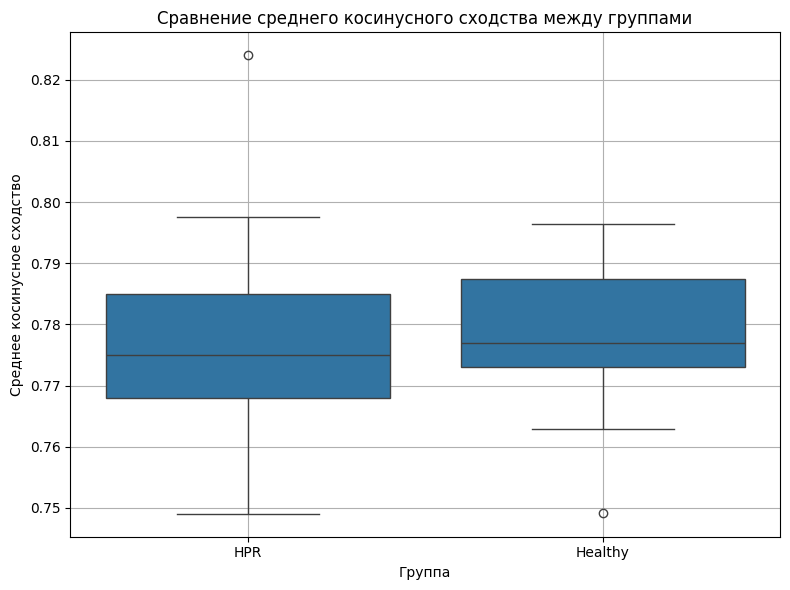

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

if "summary_df" not in locals():
    raise ValueError("Сначала нужно построить summary_df (таблица с результатами анализа).")

plt.figure(figsize=(8, 6))
sns.boxplot(data=summary_df, x="group", y="avg_similarity")
plt.title("Сравнение среднего косинусного сходства между группами")
plt.xlabel("Группа")
plt.ylabel("Среднее косинусное сходство")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def cluster_sharp_change(similarities, drop_factor=0.95):
    if len(similarities) < 2:
        return 1
    clusters = 1
    current_cluster = [similarities[0]]
    for sim in similarities[1:]:
        avg = np.mean(current_cluster)
        if sim < avg * drop_factor:
            clusters += 1
            current_cluster = [sim]
        else:
            current_cluster.append(sim)
    return clusters

summary_df["sharp_clusters_0.95"] = summary_df.apply(
    lambda row: cluster_sharp_change(
        cosine_results[row["group"]][row["filename"]],
        drop_factor=0.95
    ), axis=1
)


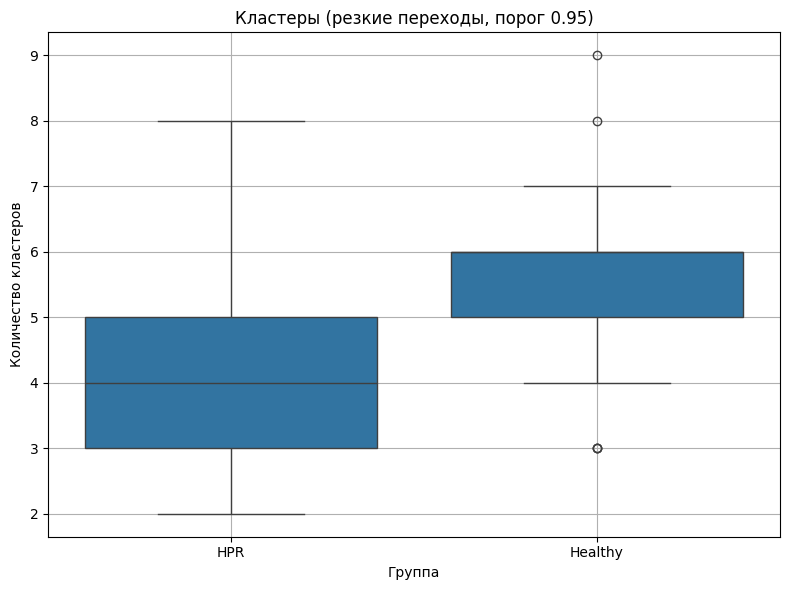

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=summary_df, x="group", y="sharp_clusters_0.95")
plt.title("Кластеры (резкие переходы, порог 0.95)")
plt.xlabel("Группа")
plt.ylabel("Количество кластеров")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
text_stats = []

for group in ["HPR", "Healthy"]:
    folder = extract_dirs[0] if group == "HPR" else extract_dirs[1]
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        words = read_words_from_file(path)
        if len(words) < 2:
            continue

        total_words = len(words)
        unique_words = len(set(words))
        repeated_words = total_words - unique_words

        similarities = cosine_results[group].get(filename, [])
        if similarities:
            median_sim = np.median(similarities)
            q25_sim = np.percentile(similarities, 25)
        else:
            median_sim = np.nan
            q25_sim = np.nan

        text_stats.append({
            "group": group,
            "filename": filename,
            "total_words": total_words,
            "unique_words": unique_words,
            "repeated_words": repeated_words,
            "median_similarity": median_sim,
            "q25_similarity": q25_sim
        })

text_stats_df = pd.DataFrame(text_stats)
text_stats_df = text_stats_df.sort_values(by=["group", "filename"]).reset_index(drop=True)

text_stats_df

,group,filename,total_words,unique_words,repeated_words,median_similarity,q25_similarity
0,HPR,PD-001.txt,17,17,0,0.773364,0.745361
1,HPR,PD-003.txt,22,22,0,0.787785,0.750972
2,HPR,PD-015.txt,21,21,0,0.779865,0.762151
3,HPR,PD-019.txt,9,9,0,0.813377,0.773289
4,HPR,PD-038.txt,26,26,0,0.778902,0.743301
5,HPR,PD-048.txt,29,29,0,0.781257,0.745095
6,HPR,PD-05.txt,31,30,1,0.770489,0.741987
7,HPR,PD-051.txt,24,24,0,0.776521,0.718969
8,HPR,PD-061.txt,11,11,0,0.812162,0.784498
9,HPR,PD-067.txt,19,19,0,0.770407,0.745512
